## Enriching and Expanding our Datasets

#### Imports

In [17]:
import pandas as pd
import json

In [18]:
with open('../data/tops/_paths.json', 'r') as fp: # Load path for top 10 song data for each artist in our dataset
    artist_paths = json.load(fp)
    
artist_ranks = pd.read_parquet('../data/wikitop100list/artists.parquet') # load the top 100 artists dataset

#### Concatenating all songs into one large dataset

In [19]:
# Initialize new dataframe that will concatenate all the top 10 songs for each of the 100 artists
artist_data = pd.DataFrame(columns = ['Rank', 'Track_Name', 'Listeners', 'Artist', 'Unique_Word_Count'])

In [20]:
for i in artist_paths.values():
    y = pd.read_parquet(i)
    artist_data = pd.concat( [artist_data,y], ignore_index = True)

#### Cleaning up and enriching our existing data

In [21]:
artist_data.rename(columns={'Rank':'Song_Rank'}) # Differentiate between song_rank within their top 10 songs and bank_rank within the top 100 artists
artist_ranks['Band_Rank'] = artist_ranks['Artist'].index + 1 # Add band rank as an official column instead of index
artist_ranks['Artist'] = artist_ranks['Artist'].apply(lambda x : x.replace(' ','_')) # Clean up
artist_data = pd.merge(artist_data,artist_ranks[['Artist','Band_Rank']], how = 'left',left_on='Artist',right_on='Artist') # Append band_rank column to our songs/artist dataset

In [37]:
# Formalizing our types for successful export
artist_data['Band_Rank'] = artist_data['Band_Rank'].apply(pd.to_numeric, downcast='integer')
artist_data['Unique_Word_Count'] = artist_data['Unique_Word_Count'].apply(pd.to_numeric, downcast='float')
artist_ranks['Start_Year'] = artist_ranks['Start_Year'].apply(pd.to_numeric, downcast='integer')
artist_ranks['End_Year'] = artist_ranks['End_Year'].apply(pd.to_numeric, downcast='float')

In [41]:
# Add to each artist their average unique word count across their top 10 songs
artist_ranks = pd.merge(artist_ranks, artist_data.groupby('Artist')['Unique_Word_Count'].aggregate('mean'), how = 'left', left_on='Artist', right_on='Artist').rename(columns={'Unique_Word_Count':'Avg_Unique_Word_Count'})

def total_unique_words(artist): # Helper function that adds up an artists' unique words across their top 10 songs
    try:
        with open('../data/lyrics/'+artist+'.json', 'r') as fp: # Load paths
            word_dict = json.load(fp)
        return (len(set(word.lower() for lyric in word_dict['distinct_words'] for word in lyric)))
    except:
        return pd.NA

artist_ranks['Total_Unique_Word_Count'] = artist_ranks['Artist'].apply(total_unique_words)

#### Exports

In [42]:
artist_ranks.to_parquet('../data/wikitop100list/artists.parquet')
artist_data.to_parquet('../data/tops/_all_artists.parquet')

### Small Data Visualization

In [46]:
data = pd.read_parquet('../data/wikitop100list/artists.parquet')
data

,Artist,Country,Release-year_of_first_charted_record,Total_certified_units,Claimed_sales,Active,Start_Year,End_Year,Band_Rank,Total_Unique_Word_Count,Avg_Unique_Word_Count
index,,,,,,,,,,,
0,The_Beatles,United Kingdom,1962,290600000.0,600000000.0,False,1960,1970.0,1,411.0,76.600000
1,Elvis_Presley,United States,1956,231800000.0,500000000.0,False,1953,1977.0,2,NaN,90.500000
2,Michael_Jackson,United States,1971,279900000.0,400000000.0,False,1964,2009.0,3,516.0,104.600000
3,Elton_John,United Kingdom,1970,208200000.0,300000000.0,True,1962,NaN,4,508.0,108.625000
4,Queen,United Kingdom,1973,184200000.0,300000000.0,True,1971,NaN,5,483.0,96.222222
...,...,...,...,...,...,...,...,...,...,...,...
97,The_Black_Eyed_Peas,United States,1998,69800000.0,80000000.0,True,1995,NaN,98,625.0,120.700000
98,Van_Halen,United States,1978,65200000.0,80000000.0,False,1978,2020.0,99,342.0,71.555556
99,Ayumi_Hamasaki,Japan,1998,64500000.0,80000000.0,True,1998,NaN,100,105.0,15.777778


#### Is there a correlation between a band's start year and their vocabulary?

<AxesSubplot: xlabel='Start_Year'>

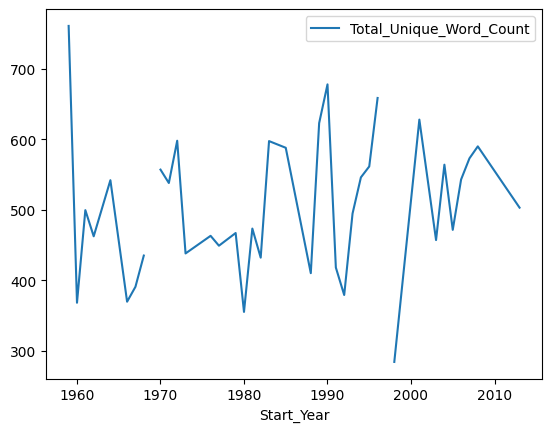

In [51]:
data[data['Active']].groupby('Start_Year').aggregate({'Total_Unique_Word_Count':'mean'}).plot()

In [52]:
# Correlation?
data[data['Active']].sort_values('Start_Year')['Start_Year'].corr(data[data['Active']].sort_values('Start_Year')['Avg_Unique_Word_Count'])

0.37687381733838415

<AxesSubplot: xlabel='Start_Year'>

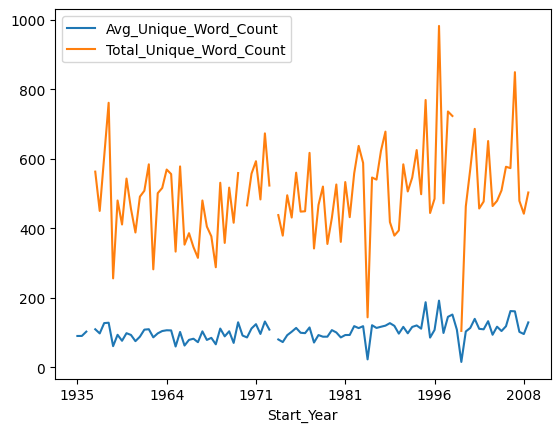

In [103]:
data.sort_values(by='Start_Year').plot.line(x='Start_Year', y=['Avg_Unique_Word_Count','Total_Unique_Word_Count'])

In [55]:
# Not a particularly strong correlation but a positive one nonetheless
data[['Start_Year','Avg_Unique_Word_Count','Total_Unique_Word_Count']].corr()

,Start_Year,Avg_Unique_Word_Count,Total_Unique_Word_Count
Start_Year,1.000000,0.370377,0.224889
Avg_Unique_Word_Count,0.370377,1.000000,0.883870
Total_Unique_Word_Count,0.224889,0.883870,1.000000


#### Are more units being sold?

<AxesSubplot: xlabel='Start_Year'>

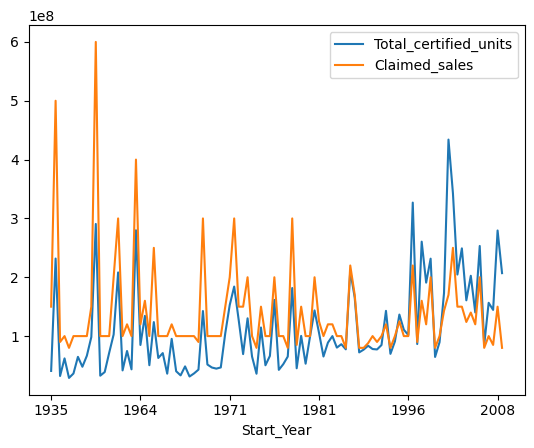

In [108]:
data.sort_values(by='Start_Year').plot(x='Start_Year', y=['Total_certified_units','Claimed_sales'])

In [57]:
data[['Start_Year','Total_certified_units','Claimed_sales']].corr()
# Looks like more units are being sold for more modern bands as they become more internationally recognized, but their sales numbers are dropping

,Start_Year,Total_certified_units,Claimed_sales
Start_Year,1.000000,0.467936,-0.170791
Total_certified_units,0.467936,1.000000,0.623720
Claimed_sales,-0.170791,0.623720,1.000000


#### Does country have anything to do with it?

In [58]:
data.groupby('Country').aggregate({'Total_Unique_Word_Count':'mean', 'Total_certified_units':'mean','Country':'count'}).sort_values('Total_Unique_Word_Count',ascending=False)
# Very few countries outside of US and UK, so any answer will lack corresponding data

,Total_Unique_Word_Count,Total_certified_units,Country
Country,,,
Trinidad and Tobago,849.000000,1.566000e+08,1
France,563.000000,2.890000e+07,1
Colombia,546.000000,7.750000e+07,1
Sweden,523.000000,6.939500e+07,1
United States,518.238095,1.071497e+08,67
Canada,498.750000,2.354875e+08,4
Ireland,495.000000,1.146000e+08,1
United Kingdom,465.850000,1.137760e+08,20
Barbados,457.000000,3.427000e+08,1
